# Analysis for virtual screening

To get the final enrichment factor, just run the first 2 cells and then the last cell.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from rdkit import Chem
from rdkit.Chem import QED, Crippen, Draw
import json
import math
from pathlib import Path

import collections
from tqdm import tqdm

In [2]:
cache_dir = Path("../official_results/virtual-screening/fingerprint-nearest-neighbours").absolute()
cache_dir.mkdir(exist_ok=True)

# Load dockstring dataset, create active lists

In [3]:
df = pd.read_csv("../data/dockstring-excape/dockstring-dataset-extra-props.tsv", sep="\t")
df

,inchikey,smiles,PPARD,ABL1,ADAM17,ADRB1,ADRB2,AKT2,MAOB,CASP3,...,GBA,MAPK1,MAPK14,PLK1,SRC,THRB,F2,KDR,logP,QED
0,UMVWYQXKBPJMOF-UHFFFAOYNA-N,C1=C(C2=C(C=C1O)OC(C(C2=O)=O)C3=CC=C(C(=C3)O)O)O,-8.2,-9.1,-9.0,-9.3,-9.7,-8.7,-8.4,-7.2,...,-9.1,-9.3,-8.3,-9.0,-8.4,-8.8,-8.2,-8.0,1.39450,0.463229
1,NGOGFTYYXHNFQH-UHFFFAOYNA-N,O=S(=O)(N1CCNCCC1)C2=CC=CC=3C2=CC=NC3,-7.1,-9.5,-7.0,-7.6,-7.7,-8.2,-6.3,-6.1,...,-8.0,-8.3,-6.9,-8.6,-7.7,-8.1,-6.8,-7.4,1.21880,0.903457
2,BGVLELSCIHASRV-QPEQYQDCNA-N,C=1C=C2S/C(/N(CC)C2=CC1OC)=C\C(=O)C,-6.6,-7.4,-5.9,-7.0,-7.0,-7.1,-6.9,-5.5,...,-6.4,-7.1,-6.3,-7.0,-6.2,-7.9,-5.8,-6.2,3.05760,0.770003
3,KTUFNOKKBVMGRW-RPGFEBOUNA-N,C=1(N=C(C=2C=NC=CC2)C=CN1)NC=3C=C(NC(C4=CC=C(C...,-10.8,-10.2,-11.0,-10.4,-11.5,-11.0,-3.3,-9.4,...,-9.3,-10.2,-8.8,-10.4,-9.5,-7.4,-9.7,-11.4,4.59032,0.389416
4,LLJRXVHJOJRCSM-UHFFFAOYNA-N,C1=CC=2C(=CNC2C=C1)C=3C=CN=CC3,-7.7,-8.6,-7.4,-8.4,-8.2,-7.7,-7.9,-6.2,...,-7.7,-8.0,-7.8,-7.9,-6.8,-8.5,-6.6,-7.8,3.22990,0.632617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260150,DWPVTFJKTGBFRK-UHFFFAOYNA-N,ClC1=CC(S(=O)(=O)N2N=NC=3C2=CC=CC3)=C(OCC)C=C1,-7.5,-9.0,-7.8,-8.1,-8.4,-7.8,-7.4,-6.9,...,-8.2,-8.3,-7.3,-8.2,-7.6,-8.7,-7.8,-7.8,2.72040,0.731436
260151,GZKYOKRGPTXXIJ-YAQRNVERNA-N,ClC=1C=CC(C(=O)NN=C2CCCC2)=CC1,-8.1,-8.6,-8.0,-8.1,-8.1,-7.3,-8.5,-6.3,...,-8.0,-7.6,-7.0,-8.2,-7.0,-8.3,-7.2,-8.2,2.99980,0.788400
260152,SFJOYBYSPNCEKG-UHFFFAOYNA-N,O=C1N(C(=O)N(C2=C3N(C(=C21)C4=CC=CC=C4)C=5C(N=...,-8.9,-10.3,-9.6,-11.5,-7.7,-8.9,-6.3,-8.9,...,-8.7,-8.8,-8.2,-10.9,-9.1,-6.3,-9.2,-7.5,4.68052,0.388036
260153,QUXNNXZZXGGGPV-UHFFFAOYNA-N,O=C(N1C=2C(C(=C1)C(OC)=O)=CC=CC2)C3=CC(=C(C=C3...,-9.6,-9.3,-9.1,-9.3,-9.7,-8.0,-8.8,-7.9,...,-8.8,-8.6,-8.3,-9.2,-8.7,-11.1,-7.7,-7.0,3.73324,0.677728


In [4]:
cutoffs = dict(KIT=-10.7, PARP1=-12.1, PGR=-10.1)
cutoffs

{'KIT': -10.7, 'PARP1': -12.1, 'PGR': -10.1}

In [5]:
# Find active and inactive sets
active_sets = collections.defaultdict(set)
for _, row in df.iterrows():
    for name, c in cutoffs.items():
        if row[name] <= c:
            active_sets[name].add(str(row["inchikey"]))

In [6]:
# Shortcut for analysis: inchikey to SMILES
inchi2smiles = {str(row["inchikey"]): str(row["smiles"]) for _, row in df.iterrows()}

# Next step:

Actually run the nearest neighbour calculations with the `find_dockstring_nearest_neighbours.py` script.

# Shortlist all molecules whose nearest neighbour is active:

In [7]:
zinc_NN_results_path = Path("../data/zinc-dockstring-nearest-neighbours/")
zinc_NN_shortlist_path = cache_dir / "mols_with_active_neighbour.json"

In [8]:
# If this directory exists, write the summary results
if zinc_NN_results_path.exists():
    
    zinc_id_shortlists = collections.defaultdict(list)
    for fname in tqdm(list(zinc_NN_results_path.glob("*.csv*"))):
        df_z = pd.read_csv(fname)

        for name, actives in active_sets.items():
            df_actives = df_z[df_z["NN_inchi"].isin(actives)]
            zinc_id_shortlists[name].extend(df_actives.to_dict('records'))
            del df_actives
    
    # Dump the results to plain text...
    with open(zinc_NN_shortlist_path, "w") as f_out:
        json.dump(zinc_id_shortlists, f_out, indent=1)
        
    del zinc_id_shortlists

100%|██████████| 4988/4988 [09:21<00:00,  8.88it/s]


In [9]:
with open(zinc_NN_shortlist_path) as f_in:
    zinc_id_shortlists = json.load(f_in)

# Some analysis:

In [10]:
print("How many potential actives for each?")
for name, l in zinc_id_shortlists.items():
    print(f"\t{name}: {len(l)}")

How many potential actives for each?
	PGR: 2246478
	KIT: 946768
	PARP1: 1050799


In [11]:
print("How many molecules with similarity 1 to the training set (actives)?")
for name, l in zinc_id_shortlists.items():
    n = sum(1 for d in l if d["NN_dist"] >= 1.0)
    print(f"\t{name}: {n}")

How many molecules with similarity 1 to the training set (actives)?
	PGR: 553
	KIT: 358
	PARP1: 369


In [12]:
n = 5000
print(f"Exclude mols with sim 1, how close is the {n}th best molecule?")
for name, l in zinc_id_shortlists.items():
    l2 = [d for d in l if d["NN_dist"] < 1.0]
    l2 = sorted(l2, reverse=True, key=lambda d: d["NN_dist"])
    l2 = l2[:n]
    print(f"\t{name}: {l2[-1]['NN_dist']:.3g}")
    del l2

Exclude mols with sim 1, how close is the 5000th best molecule?
	PGR: 0.911
	KIT: 0.849
	PARP1: 0.888


# Find the ZINC SMILES for these molecules

In [13]:
zinc_ids = set()
for name, l in zinc_id_shortlists.items():
    for d in l:
        zinc_ids.add(d['zinc_id'])
len(zinc_ids)

4118817

In [14]:
zinc_id_to_smiles = dict()
with open("../data/zinc/zinc20-sorted.csv") as f:
    next(f)
    for line_num, line in tqdm(enumerate(f)):
        line = line.strip()
        _comma_idx = line.index(",")
        z_id = int(line[0:_comma_idx])
        if z_id in zinc_ids:
            zinc_id_to_smiles[z_id] = line[_comma_idx+1:]

997597003it [11:22, 1461194.06it/s]


In [15]:
list(zinc_id_to_smiles.items())[:5]

[(277, 'CC/N=C1\\Nc2ccc(Cl)cc2[C@](C)(c2ccccc2)O1'),
 (706, 'C[n+]1cc2c3c(ccc2c2ccc4cc5c(cc4c21)OCO5)OCO3'),
 (1364, 'C[C@@]12CCc3c4ccc(O)cc4ccc3[C@H]1CCC2=O'),
 (1738, 'O=C1c2cn3c(c2C(=O)c2ccccc21)Cc1ccccc1C3'),
 (3275, 'Nc1c2ccccc2nc2c1CCc1ccccc1-2')]

# Try outputting these most similar mols to a file

In [16]:
for name, l in zinc_id_shortlists.items():
    l_sorted = sorted(l, reverse=True, key=lambda d: d["NN_dist"])
    with open(cache_dir / f"top-v1-{name}.csv", "w") as f:
        f.write("\n".join(zinc_id_to_smiles[d["zinc_id"]] for d in l_sorted[:5000]))

# Now, dock these molecules (not done here, but the results are in the "official results" folder)

# Input these molecules: what are the enrichment factors like?

In [19]:
for name in cutoffs:
    
    tmp_df = pd.read_csv(cache_dir / f"{name}_top-v1-{name}.csv", header=None, names=["smiles", "docking"])
    
    num_above = np.sum(tmp_df.docking.values <= cutoffs[name])
    num_above_other = np.sum(tmp_df.docking.values <= cutoffs[other])
    print(f"{name}: ef={num_above/len(tmp_df) / 1e-3:.4g}")#, ef_{other}={num_above_other/len(tmp_df) / 1e-3:.3g}")

KIT: ef=239.2
PARP1: ef=313.1
PGR: ef=161.4


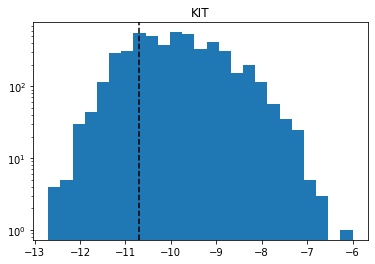

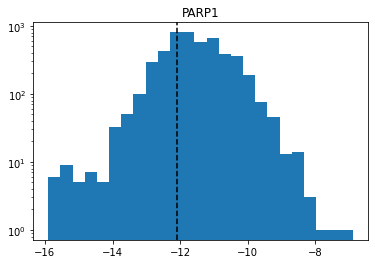

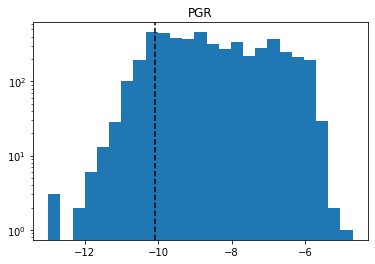

In [18]:
# Visualize the distribution
for name in cutoffs:
    
    tmp_df = pd.read_csv(cache_dir / f"{name}_top-v1-{name}.csv", header=None, names=["smiles", "docking"])
    
    plt.hist(tmp_df.docking.values, bins=25)
    plt.axvline(cutoffs[name], linestyle="--", color="k")
    plt.yscale("log")
    plt.title(name)
    plt.show()